# Modelo Presa-Depredador
**Cristian Leilael Rico Espinosa.   
Matrícula: A01707023.**

## Introducción
En ecología, la depredación es un tipo de interacción biológica en la que el individuo de una especie animal, denominado depredador, caza al individuo de otra especie, la presa, para subsistir. Un mismo individuo puede ser depredador de algunos animales y a su vez presa de otros, aunque en todos los casos el predador es carnívoro u omnívoro. Esta interacción ocupa un rol importante en la selección natural.

Los modelos matemáticos de depredación se encuentran entre los más antiguos de la ecología. Uno de los primeros fue propuesto por Thomas Robert Malthus (1766-1834), quien planteó un modelo unidimensional sobre la población humana. En su obra "An Essay on the Principle of Population as It Afects the Future Improvements of Society" (Malthus, 1809) intentó mostrar que "el crecimiento de la población humana sería más rápido que la producción de sustento y que no se alcanzaba esta situación debido a otros factores que frenaban el crecimiento natural de los humanos" (Oganician, 2017). Después de que el modelo unidimensional presentado por Malthus resultará ser uno de los más sencillos, dado que solo consideraba nacimientos y muertes, el biológo y matemático P.F. Verhulst logro mejorar el modelo de Malthus presentando el modelo logístico, en donde se tenía en cuenta la interacción de los individuos mediante una probabilidad de encuentro entre estos (García Montoya et al., 2019).

## Descripción

En esta actividad, diseñaremos un modelo presa-depredador que nos muestre la interacción entre tres especies. 

Cenitune, es un curioso exoplaneta de forma rectangular que se encuentra a más 4 millones años luz de la tierra. Este planeta es el sueño dorado de cualquier exobiólogo ya que cuenta con un ecosistema muy pequeño, pero no por ello simple. 

Toda la superficie de Cenitune se encuentra cubierta por una única especie de hierba. Esta hierba es el alimento de una raza llamada nonine. Los nonine son hervíboros pequeños que se pasan la vida muy felices comiendo y reproduciéndose. Bueno, la mayor parte del tiempo, ya que tiene que cuidarse de los deddian. Los deddian son los único carnívoros de Cenitune y su único alimento son los nonine.

### Reglas generales del modelo
* Dos nonine no pueden ocupar la misma sección.
* Dos deddian no pueden ocupar la misma sección.
* Cada nonine solo puede comer hierba si no ha llegado a su máxima capacidad de comida.
* Un deddian no se comerá un nonine si ha sobrepasado su capacidad máxima de comida.
* Nonines y deddians solo puede reproducirse cuando han llegado a cierta edad y ha logrado una cierta capacidad de comida.
* Un nonine no puede reproducirse si hay un deddian a su alrededor.
* Nonines y deddians solo pueden mover hacia arriba, abajo, izquierda o derecha de su posición actual.
* Nonines y deddians mueren si son muy viejos o si no han comido lo suficiente.
* La hierba tiene una tasa de crecimiento de 1 unidad/ciclo.

### Simulación
* El planeta tenga un ancho y alto de 35 celdas.
* Inicialmente, habrá 47 nonines y 15 deddians.
* Todos los campos empiezan con 20 unidades de hierba.
* La simulación se realizará durante 200 iteraciones.
* Deberá visualizar la evolución del modelo.

In [1]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid, MultiGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation, RandomActivation, RandomActivationByType

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

from random import *

## Definición de Agentes

### Nonines

* Capacidad máxima de comida: 45 unidades.
* Tasa de metabolismo: 3 unidades/ciclo.
* Probilidad de reproducción en un ambiente adecuada: 50%
* Edad mínima de reproducción: 10 ciclos.
* Requisito mínimo de alimento para reproducirse: 40 unidades.
* Edad máxima: 25 etapas.
* Comida inicial: 10
* Un nonine le da un valor de comida de 10 a un deddian cuando se lo come.

En cada ciclo, 
* Un nonine se mueve aleatoriamente a uno de los cuatro campos vecinos, siempre que esté vacío (no existe otro nonine o deddian). Este movimiento le consume una cierta cantidad de la comida que ha ingerido. Si no hay celdas vecinas libres, no se produce movimiento.  
* Si no ha llegado a su capacidad máxima de comida, consumirá toda lo que hay en ese campo (hasta el límite definido). 
* Al superar su tiempo de reproducción predefidino, el nonine dará a a luz un nuevo nonine siempre y cuando tenga la energía necesaria y esté en un ambiente adecuado. El nuevo nonine se deberá generar en una celda vecina vacía. Si no se cumple alguno de estos requisitos, no se generará ningún nuevo nonine.

In [2]:
class Nonine(Agent):
    def __init__(self, unique_id, position, model, food = 10, multiply_rate = 0.5):
        super().__init__(unique_id, model)
        self.position = position
        self.food = food
        self.multiply_rate = multiply_rate
        self.type = 1
        self.life = 1
        
    def move(self):     
        new_position = self.move_options()       
        if not new_position == self.position and model.grid.is_cell_empty(new_position):
            self.model.grid.move_agent(self, new_position)
            
    def move_options(self):
        possible_steps = []
        for (x, y) in self.model.grid.iter_neighborhood(self.position, moore=False, include_center=False):
            if (self.model.grid.is_cell_empty((x, y))):
                possible_steps.append((x, y))               
        if len(possible_steps) == 0:
            return None    
        return self.random.choice(possible_steps)
            
    def multiply(self):
        possibility = (randint(1, 100)) * self.multiply_rate         
        new_position = self.move_options() 
        if model.grid.is_cell_empty(new_position) and not self.position:
            if self.life >= 10 and self.food >= 40 and possibility > 30:                
                a = Nonine(self.model.next_id(), (new_position), self.model)
                self.model.grid.place_agent(a, (new_position))
                self.model.schedule.add(a)    
            else:
                return
        else:
            return
               
    def eat(self):
        if self.model.floor[(self.position)].any():
            for self.food in range (44):
                self.food += 1
                self.model.floor[self.position] -= 1
                    
    def step(self): 
        self.food -= 3 
        print ("Nonine %i: Comida --> %i  Vida --> %i" % (self.unique_id, self.food, self.life))
        if self.life == 25 or self.food <= 0:      
            self.model.kill_agentsN.append(self)
        else: 
            self.eat()
            self.multiply()
            self.move()
            
        self.life += 1            

### Deddian
* Capacidad máxima de comida: 200 unidades.
* Tasa de metabolismo: 2 unidades/ciclo.
* Probilidad de reproducción en un ambiente adecuada: 50%
* Edad mínima de reproducción: 10 ciclos.
* Requisito mínimo de alimento para reproducirse: 120 unidades.
* Edad máxima: 50 etapas.
* Comida inicial: 150

En cada ciclo, 
* Un deddian se mueve aleatoriamente a uno de los cuatro campos vecinos, siempre que no haya otro deddian. Este movimiento le consume una cierta cantidad de la comida que ha ingerido. Si no hay celdas vecinas libres de deddians, no se produce movimiento.  
* Si se encuentra con un nonine y no ha sobrepasado su capacidad máxima, se lo comerá. Obteniendo una cantidad de energía definida.
* Al superar su tiempo de reproducción predefidino, el deddian dará a a luz un nuevo deddian siempre y cuando tenga la energía necesaria y esté en un ambiente adecuado. El nuevo deddian se deberá generar en una celda vecina vacía. Si no se cumple alguno de estos requisitos, no se generará ningún nuevo deddian.

In [3]:
class Deddian(Agent):
    def __init__(self, unique_id, position, model, food = 150, multiply_rate = 0.5):
        super().__init__(unique_id, model)
        self.position = position
        self.food = food
        self.multiply_rate = multiply_rate
        self.type = 2
        self.life = 1
    
    def move(self):     
        new_position = self.move_options()       
        if not new_position == self.position and model.grid.is_cell_empty(new_position):
            self.model.grid.move_agent(self, new_position)               
        else:
            if self.food < 205:
                self.food += 10
            (x, y) = new_position
            self.model.delete_non(self.model.grid[x][y])
            
    def move_options(self):
        possible_steps = []
        for (x, y) in self.model.grid.iter_neighborhood(self.position, moore=False, include_center=False):
            if (self.model.grid.is_cell_empty((x, y)) or self.model.grid.get_cell_list_contents((x, y))[0].type == 1):
                possible_steps.append((x, y))               
        if len(possible_steps) == 0:
            return None    
        return self.random.choice(possible_steps)
        
    def multiply(self):
        possibility = (randint(1, 100)) * self.multiply_rate         
        new_position = self.move_options() 
        if model.grid.is_cell_empty(new_position) and not self.position:
            if self.life >= 10 and self.food >= 120 and possibility > 30:
                a = Deddian(self.model.next_id(), (new_position), self.model)
                self.model.grid.place_agent(a, (new_position))
                self.model.schedule.add(a) 
            else:
                return 0
        else:
            return 0
        
    def step(self):
        self.food -= 2
        if self.life == 50 or self.food <= 0:
            self.model.kill_agentsD.append(self)
        else:
            self.multiply()
            print ("-- Deddian %i:  Comida --> %i  Vida --> %i --" % (self.unique_id, self.food, self.life))
            self.move()
        self.life += 1

## Creación de Modelo

In [4]:
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for (content, x, y) in model.grid.coord_iter():
        if not model.grid.is_cell_empty( (x, y) ) :
            grid[x][y] = content.type
        else:
            grid[x][y] = 5
    return grid 

In [5]:
class Cenitune(Model):
    def __init__(self, nonines, deddians, width, height):
        self.nonines = nonines
        self.deddians = deddians
        self.width = width
        self.height = height
        self.floor =  np.zeros((self.width, self.height))
        self.floor.fill(20)
        self.current_id = 0
        self.grid = SingleGrid(width, height, False)
        self.schedule =  RandomActivationByType(self)
        self.kill_agentsN = []
        self.kill_agentsD = []
        
        for i in range (self.nonines + self.deddians):
            (x, y) = self.grid.find_empty()
            if i < self.nonines:
                a = Nonine(self.next_id(), (x, y), self)
                self.grid.place_agent(a, (x,y))
                self.schedule.add(a)       
            else:
                a = Deddian(self.next_id(), (x, y), self)
                self.grid.place_agent(a, (x,y))
                self.schedule.add(a)
                
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
    
    def next_id(self):
        self.current_id += 1
        return self.current_id
    
    def delete_agent(self):
        for x in self.kill_agentsN:
            self.grid.remove_agent(x)
            #self.schedule.remove(x)
            self.kill_agentsN.remove(x)
            
        for h in self.kill_agentsD:
            self.grid.remove_agent(h)
            #self.schedule.remove(h)
            self.kill_agentsD.remove(h) 
            
    def delete_non(self, coor):
        self.grid.remove_agent(coor)
        self.schedule.remove(coor)
            
    def step(self):
        self.delete_agent()
        self.floor += 1
        self.datacollector.collect(self)
        self.schedule.step()

## Ejecución del Código

In [6]:
# Definimos el tamaño del Grid
"""GRID_SIZE = 35
nonines = 2
deddians = 5"""


GRID_SIZE = 35
nonines = 47
deddians = 15

# Definimos el número máximo de generaciones a correr
MAX_GENERATIONS = 200
#MAX_GENERATIONS = 80

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()
model = Cenitune(nonines, deddians, GRID_SIZE, GRID_SIZE)
for i in range(MAX_GENERATIONS):
    model.step()
    
# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

-- Deddian 59:  Comida --> 148  Vida --> 1 --
-- Deddian 49:  Comida --> 148  Vida --> 1 --
-- Deddian 57:  Comida --> 148  Vida --> 1 --
-- Deddian 54:  Comida --> 148  Vida --> 1 --
-- Deddian 48:  Comida --> 148  Vida --> 1 --
-- Deddian 50:  Comida --> 148  Vida --> 1 --
-- Deddian 58:  Comida --> 148  Vida --> 1 --
-- Deddian 61:  Comida --> 148  Vida --> 1 --
-- Deddian 53:  Comida --> 148  Vida --> 1 --
-- Deddian 62:  Comida --> 148  Vida --> 1 --
-- Deddian 60:  Comida --> 148  Vida --> 1 --
-- Deddian 56:  Comida --> 148  Vida --> 1 --
-- Deddian 55:  Comida --> 148  Vida --> 1 --
-- Deddian 51:  Comida --> 148  Vida --> 1 --
-- Deddian 52:  Comida --> 148  Vida --> 1 --
Nonine 14: Comida --> 7  Vida --> 1
Nonine 19: Comida --> 7  Vida --> 1
Nonine 4: Comida --> 7  Vida --> 1
Nonine 13: Comida --> 7  Vida --> 1
Nonine 41: Comida --> 7  Vida --> 1
Nonine 30: Comida --> 7  Vida --> 1
Nonine 47: Comida --> 7  Vida --> 1
Nonine 22: Comida --> 7  Vida --> 1
Nonine 6: Comida --> 7 

In [7]:
all_grid = model.datacollector.get_model_vars_dataframe()
#print (all_grid)

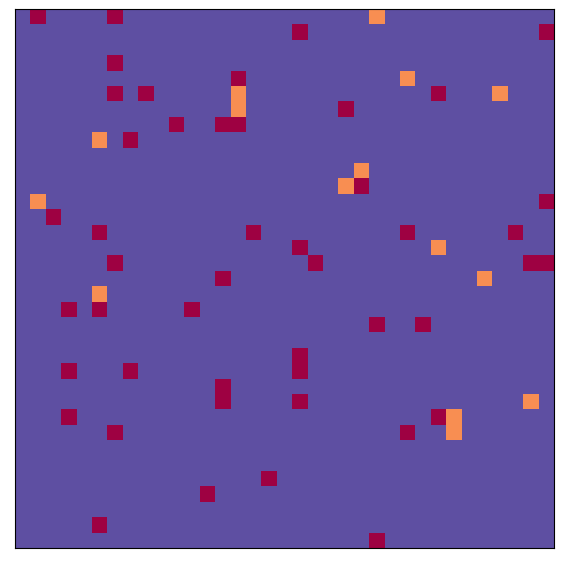

In [8]:
fig, axs = plt.subplots(figsize = (7, 7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap = plt.cm.Spectral)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames = MAX_GENERATIONS)

In [9]:
anim